Notebook used to find the best parameter values for the grouping stage of the CoDEx pipeline

In [1]:
# nlp
import numpy as np
import pandas as pd
import tqdm
from matplotlib import pyplot as plt
## machine learning
from sentence_transformers import SentenceTransformer
# clustering and dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score

In [2]:
## homegrown library functions
from imp import reload

import concept_processing.io
reload(concept_processing.io)
# for loading original data

# nlp functionality for extracting concepts from text
import concept_processing.extraction
reload(concept_processing.extraction)

# dealing with the concepts as strings
import concept_processing.concepts
reload(concept_processing.concepts)
from concept_processing.concepts import build_embedding_matrix

# manipulating data as a presence/absence matrix
import concept_processing.pam
reload(concept_processing.pam)
from concept_processing.pam import count_datapoints_in_each_feature

from concept_processing.io import load_concept_objects

import concept_processing.labels
reload(concept_processing.labels)
from concept_processing.labels import label_indices_to_one_hot
from concept_processing.labels import calculate_concept_purity_measures

import concept_processing.grouping
reload(concept_processing.grouping)
from concept_processing.grouping import calc_prox_mtx_embedding
from concept_processing.grouping import _calc_prox_mtx_labels_evidence_ratio, _calc_prox_mtx_labels_beta_ratio
from concept_processing.grouping import calc_prox_mtx_labels

# Dendrogram/hierarchical clustering
import concept_processing.plot_support
reload(concept_processing.plot_support)


/tmp/ipykernel_3563959/3565074879.py:2: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


<module 'concept_processing.plot_support' from '/home/rp218/luke-for-roko/concept_processing/plot_support.py'>

### Load the stored data

In [3]:
datapath = "for_hyperparameter_tuning.pkl"

concepts, ids, categories, labels_as_indices, pam = load_concept_objects(datapath)
labels = label_indices_to_one_hot(labels_as_indices, K=len(categories))
concept_counts = count_datapoints_in_each_feature(pam)

### Load the manually labelled data

We have stored the manually labelled data in a csv file with the column `manual_id`. Note that those concepts that have not been assigned to a cluster are ignored for the time being (given -1). This means we will miss those clustering techniques that perform badly on non-included forms. Alternatively, we can include additional labels to those -1 points (assuming each is their own cluster), which will penalise those measures that find clusters we haven't labelled.

In [4]:
reference_concept_groupings = pd.read_csv('grouping_with_new_hyperparameters.csv')
reference_concept_groupings

,manual_id,final_id,group_id,start_id,freq,text
0,0,0,16,135,57,The batter didn't swing.
1,0,0,16,392,7,Batter did not swing.
2,0,0,16,403,7,The batter did nt swing.
3,0,0,16,45,202,The batter did not swing.
4,1,1,26,266,9,Batter missed.
...,...,...,...,...,...,...
501,-1,-1,93,418,5,The pitch did not cross the plate.
502,-1,-1,94,495,9,The ball was not thrown.
503,-1,-1,95,397,3,The batter popped the ball up.
504,-1,-1,96,225,4,The hitter hit a fly ball.


In [5]:
# get the reference ids
manual_ids = reference_concept_groupings['manual_id'].to_numpy()
filter_ = manual_ids >= 0
manual_ids_trimmed = manual_ids[filter_]
print(manual_ids_trimmed[:20])
raw_ids_trimmed = reference_concept_groupings['start_id'].to_numpy()[filter_]
print(f"raw_ids_trimmed[:20] = {raw_ids_trimmed[:20]}")

[0 0 0 0 1 1 1 2 3 3 3 3 3 2 3 2 3 2 2 3]
raw_ids_trimmed[:20] = [135 392 403  45 266  30  42  17 179  19 191 195 196 238 251 257 264 265
 284 326]


## Concept Similarity

### BERT with `SentenceTransformer`

Requires installation of the sentence-transfomer library with:

`pip install -U sentence-transformers`

In this part, we consider that modern sentence embedding models can be used to generate vector representations for sentences or phrases and then arithmetic operations performed on those vectors. IN particular, we are interested in measuring the distance between phrases so that we can consider merging apparently distinct but semantically similar concepts into a single umbrella concept.


In [6]:
distilroberta_model = SentenceTransformer('paraphrase-distilroberta-base-v1')
stsb_roberta_model =  SentenceTransformer('stsb-roberta-base')

In [7]:
# we fix the model and then build a matrix of embedding vectors over the concepts
embeds_distil = build_embedding_matrix(concepts, distilroberta_model)
embeds_stsb = build_embedding_matrix(concepts, stsb_roberta_model)
embeds_lookup = dict(distil=embeds_distil, stsb=embeds_stsb)


In [8]:
# for the label distance
label_counts_mtx, concept_mean_labels = calculate_concept_purity_measures(pam, labels)
alpha = 0.5 # symmetric prior of the dirichlet
_calc_prox_mtx_labels_beta_ratio(label_counts_mtx, alpha=alpha)

array([[2.52542467e-01, 3.39889567e-01, 4.92449518e-01, ...,
        1.01403136e+03, 1.01403136e+03, 1.01403136e+03],
       [3.39889567e-01, 4.37055587e-01, 5.26231466e-01, ...,
        5.04446447e+02, 5.04446447e+02, 5.04446447e+02],
       [4.92449518e-01, 5.26231466e-01, 2.19526033e-02, ...,
        7.23577984e+03, 2.58420709e+04, 8.61402362e+03],
       ...,
       [1.01403136e+03, 5.04446447e+02, 7.23577984e+03, ...,
        2.56027833e+00, 4.26713055e+00, 1.28013916e+01],
       [1.01403136e+03, 5.04446447e+02, 2.58420709e+04, ...,
        4.26713055e+00, 1.93960480e+00, 8.96097415e+01],
       [1.01403136e+03, 5.04446447e+02, 8.61402362e+03, ...,
        1.28013916e+01, 8.96097415e+01, 1.93960480e+00]])

In [9]:
    
def evaluate_adj_rand_level0(results_dict, modelnames, embeds_lookup, *args, **kwargs):
    #pbar = tqdm.tqdm(num_iterations)
    for modelname in modelnames:
        embeds = embeds_lookup[modelname]
        evaluate_adj_rand_level1(results_dict, embeds, *args, modelname=modelname, **kwargs)
        
def evaluate_adj_rand_level1(results_dict, embeds, metrics, *args, **kwargs):
    for metric in metrics:
        prox_mtx_embedding = calc_prox_mtx_embedding(embeds, metric)
        evaluate_adj_rand_level2(
            results_dict, prox_mtx_embedding, *args, metric=metric, **kwargs)

def evaluate_adj_rand_level2(
        results_dict, prox_mtx_embedding, labelmetrics, alphas, *args, **kwargs):
    for labelmetric in labelmetrics:
        for alpha in alphas:
            prox_mtx_labels = calc_prox_mtx_labels(label_counts_mtx, alpha, labelmetric)
            evaluate_adj_rand_level3(
                results_dict, prox_mtx_embedding, prox_mtx_labels, *args,
                alpha=alpha, labelmetric=labelmetric, **kwargs)

def evaluate_adj_rand_level3(
        results_dict, prox_mtx_embedding, prox_mtx_labels, lambdas, *args, rescaling=None, metric=None, **kwargs):
    for lambda_ in lambdas:
        if rescaling is None:
            rescale_val = 1.
        elif isinstance(rescaling, dict):
            rescale_val = rescaling[metric]
        prox_mtx_total = prox_mtx_embedding + lambda_ * rescale_val * prox_mtx_labels
        evaluate_adj_rand_level4(
            results_dict, prox_mtx_total, *args, metric=metric, lambda_=lambda_, rescaling=rescale_val, **kwargs)

def evaluate_adj_rand_level4(
        results_dict, prox_mtx_total, linkages, pbar=None, thresholds=None, n_clusters_seq=None,
        **kwargs):
    # range through n values log separated from just above min to just below max
    # distance found in the proximity matrix.
    #logmin = np.log(np.min(prox_mtx_total))
    #logmax = np.log(np.max(np.min(prox_mtx_total, axis=0)))
    #if thresholds is None:
    #    thresholds = np.logspace(logmin, logmax, n_thresholds+2)[1:-1]
    #else:
    #    print(f"lower_dist = {np.exp(logmin)}")
    #    print(f"upper_dist = {np.exp(logmax)}")
#    for threshold in thresholds:
    for linkage in linkages:
        for threshold in thresholds:
            try:
                model = AgglomerativeClustering(
                    distance_threshold=threshold, n_clusters=None, linkage=linkage,
                    affinity='precomputed')
                model = model.fit(prox_mtx_total)
                # we only compare label accuracy on those chosen to be manually labelled
                labels_trimmed = model.labels_[raw_ids_trimmed]
                adj_rand = adjusted_rand_score(manual_ids_trimmed, labels_trimmed)
            except Exception as e:
                print(f"""Failed with: 
                    modelname = {kwargs['modelname']},
                    metric = {kwargs['metric']}
                    labelmetric = {kwargs['labelmetric']},
                    alpha = {kwargs['alpha']},
                    lambda_ = {kwargs['lambda_']},
                    linkage = {linkage},
                    threshold = {threshold}.
                    """)
                print(e)
            else:
                # Save the model results
                results_dict['model'].append(kwargs['modelname'])
                results_dict['metric'].append(kwargs['metric'])
                results_dict['labelmetric'].append(kwargs['labelmetric'])
                results_dict['alpha'].append(kwargs['alpha'])
                results_dict['lambda'].append(kwargs['lambda_'])
                results_dict['threshold'].append(threshold)
                results_dict['linkage'].append(linkage)
                results_dict['adj_rand'].append(adj_rand)
                results_dict['rescaling'].append(rescaling)
            if not pbar is None:
                pbar.update(1)


In [10]:
test_results_dict = None
if test_results_dict is None:
    test_results_dict = {k:list() 
        for k in ['model', 'metric', 'labelmetric', 'alpha', 'lambda', 'threshold', 'adj_rand', 'linkage', 'rescaling']}

In [11]:
#test_results_dict['rescaling'] = [1.]*len(test_results_dict['model'])

In [12]:
def convert_results_dictionary_to_dataframe(results_dict):
    # convert results dictionary to dataframe
    for k,v in results_dict.items():
        print(f"key:{k}, length: {len(v)}")
    results_df = pd.DataFrame(results_dict)
    return results_df

In [13]:
# TODO: this line was inserted but it doesn't seem to have much benefit
test_results_df = pd.DataFrame(test_results_dict)
test_results_df[(test_results_df.adj_rand>=0.799)]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling


In [14]:
# rerunning experiments to  fill in some blanks
#modelnames = ['stsb','distil']
modelnames = ['stsb']
#modelnames = ['distil']
#metrics = ['cosine', 'manhattan', 'minkowski', 'chebyshev']
#metrics = ['cosine']
#rescaling = 1.
#rescaling = 0.08 # for bayes ratio
metrics = ['manhattan', 'cosine'] # ['manhattan']
rescaling=720.
#rescaling = 55. # for bayes ratio
#metrics = ['chebyshev']
#rescaling=5.
#metrics = ['minkowski']
#rescaling=4.36
#rescaling = 0.33 # for bayes ratio
labelmetrics = ['evidence_ratio', 'beta_ratio'] # ['evidence_ratio']
#labelmetrics = ['beta_ratio']
alphas = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
#alphas = [0.01, 0.2, 0.5, 1]
lambdas = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
#lambdas = [0.6,0.8,1.]
#lambdas = []
#n_clusters_seq = list(range(400,470,10))
#n_clusters_seq = list(range(460,530,10))
thresholds = np.logspace(np.log10(90), np.log10(350), 9)
print(thresholds)
## ward and complete can throw errors for some reason
#linkages = ['ward', 'complete', 'average', 'single']
linkages = ['single']
#linkages = ['average']

# Failed with
#                    metric = manhattan
#                    labelmetric = beta_ratio,
#                    alpha = 0,
#                    lambda_ = 0.5,
#                    linkage = single,
#                    threshold = 168.36930724640604.

                    
metric_to_rescaling = {
    'manhattan': 720,
    'cosine': 1,
}

[ 90.         106.65241682 126.38597792 149.77077774 177.48239349
 210.32140231 249.23650961 295.35195676 350.        ]


In [15]:
total_iterations = 1
total_iterations *= len(modelnames)
total_iterations *= len(metrics)
total_iterations *= len(labelmetrics)
total_iterations *= len(alphas)
total_iterations *= len(lambdas)
total_iterations *= len(thresholds)


pbar = tqdm.tqdm(total=total_iterations)
evaluate_adj_rand_level0(
    test_results_dict, modelnames, embeds_lookup, metrics, labelmetrics, alphas,
    lambdas, linkages, n_clusters_seq=None, thresholds=thresholds, pbar=pbar, rescaling=metric_to_rescaling)
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2160/2160 [07:47<00:00,  4.62it/s]


In [16]:
test_results_df = convert_results_dictionary_to_dataframe(test_results_dict)
test_results_df.to_csv('./test_clustering_results.csv', index=False)

key:model, length: 2160
key:metric, length: 2160
key:labelmetric, length: 2160
key:alpha, length: 2160
key:lambda, length: 2160
key:threshold, length: 2160
key:adj_rand, length: 2160
key:linkage, length: 2160
key:rescaling, length: 2160


### Plotting around best parameters


In [17]:
refreeze_results = True
if refreeze_results:
    plotting_results_df = test_results_df
plotting_results_df[plotting_results_df.adj_rand == plotting_results_df.adj_rand.max()]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling
436,stsb,manhattan,evidence_ratio,0.9,0.05,177.482393,0.960279,single,720.0
490,stsb,manhattan,evidence_ratio,1.0,0.05,177.482393,0.960279,single,720.0


In [18]:
plotting_results_df[plotting_results_df.adj_rand > 0.6]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling
5,stsb,manhattan,evidence_ratio,0.1,0.05,210.321402,0.834496,single,720.0
6,stsb,manhattan,evidence_ratio,0.1,0.05,249.236510,0.690784,single,720.0
15,stsb,manhattan,evidence_ratio,0.1,0.10,249.236510,0.611921,single,720.0
26,stsb,manhattan,evidence_ratio,0.1,0.20,350.000000,0.638128,single,720.0
58,stsb,manhattan,evidence_ratio,0.2,0.05,177.482393,0.609951,single,720.0
...,...,...,...,...,...,...,...,...,...
1057,stsb,manhattan,beta_ratio,1.0,0.30,177.482393,0.678451,single,720.0
1065,stsb,manhattan,beta_ratio,1.0,0.40,149.770778,0.909176,single,720.0
1066,stsb,manhattan,beta_ratio,1.0,0.40,177.482393,0.678451,single,720.0
1074,stsb,manhattan,beta_ratio,1.0,0.50,149.770778,0.909176,single,720.0


In [19]:
distil_results_df = plotting_results_df[plotting_results_df.model != 'stsb']
distil_results_df[distil_results_df.adj_rand == distil_results_df.adj_rand.max()]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling


In [20]:
best_model = 'stsb'
best_metric = 'manhattan'
best_labelmetric = 'beta_ratio'
best_alpha = 1
best_lambda = 0.2
best_threshold = 150
#stable_threshold = 150

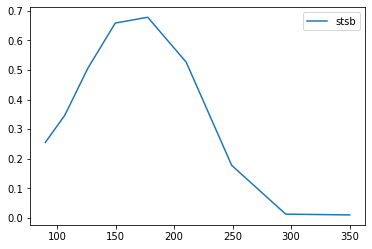

In [21]:
segment = plotting_results_df[
    (plotting_results_df.model == best_model)
    & (plotting_results_df.metric == best_metric)
    & (plotting_results_df.labelmetric == best_labelmetric)
    & (plotting_results_df.alpha == best_alpha)
    & (plotting_results_df['lambda'] == best_lambda)
    ]
threshold = segment.threshold.to_numpy()
adj_rands = segment.adj_rand.to_numpy()
plt.plot(threshold, adj_rands, label=f'{best_model}')

#n_clusters = segment_alt.n_clusters.to_numpy()
#adj_rands = segment_alt.adj_rand.to_numpy()
#plt.plot(n_clusters, adj_rands, label=f'{"distil_roberta"}')
plt.legend()


In [22]:
def plot_thresholds_perf_all_metrics(results, model, labelmetric, all_metrics):
    model_results = results[(results.model == model) & (results.labelmetric == labelmetric)]
    for metric in all_metrics:
        print(f"getting for metric {metric}")
        metric_results = model_results[(model_results.metric == metric)]
        best_row = metric_results[metric_results.adj_rand == metric_results.adj_rand.max()]
        best_alpha = best_row.alpha.to_numpy()[0]
        best_lambda = best_row['lambda'].to_numpy()[0]
        #best_labelmetric = best_row.labelmetric.to_numpy()[0]
        best_model = best_row.model.to_numpy()[0]
        best_linkage = best_row.linkage.to_numpy()[0]
        best_rescaling = best_row.rescaling.to_numpy()[0]
        thresholds, adj_rands = get_thresholds_vs_adj_rand(
            metric_results, best_model, metric, labelmetric, best_alpha, best_lambda, best_linkage, best_rescaling)
        # reorder results for nice plotting
        reorder = np.argsort(thresholds)
        thresholds_seq = thresholds[reorder]
        adj_rands = adj_rands[reorder]
        plt.plot(thresholds_seq, adj_rands, label=f'{metric}')
    plt.title(f"Model {modelname}, Label-metric: {labelmetric}")
    plt.xlabel("threshold")
    plt.ylabel("Adj. Rand Score")
    plt.legend()
    plt.tight_layout()

def get_thresholds_vs_adj_rand(results, model, metric, labelmetric, alpha, lambda_, linkage, rescaling ):
    segment = results[
        (results.model == model)
        & (results.metric == metric)
        & (results.labelmetric == labelmetric)
        & (results.alpha == alpha)
        & (results['lambda'] == lambda_)
        & (results.linkage == linkage)
        & (results.rescaling == rescaling)]
    thresholds = segment.threshold.to_numpy()
    adj_rands = segment.adj_rand.to_numpy()
    return  thresholds, adj_rands

In [23]:
plotting_results_df[
    (plotting_results_df.linkage == 'complete')
    & (plotting_results_df.adj_rand > 0.75)
    ]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling


getting for metric manhattan
getting for metric cosine
getting for metric manhattan
getting for metric cosine


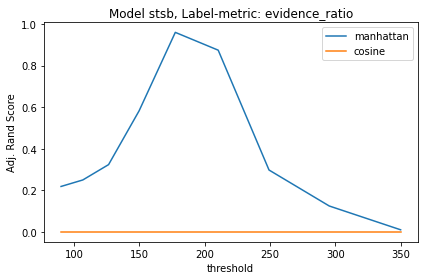

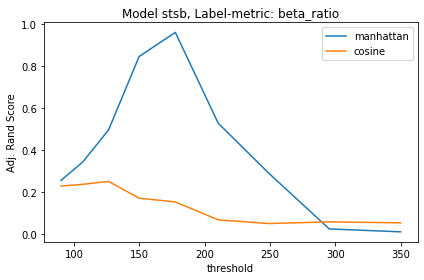

In [24]:
# TODO: ask Luke what this is for

all_metrics = ['manhattan', 'cosine'] #['cosine', 'manhattan', 'minkowski','chebyshev']
modelnames = ['stsb'] # ['stsb', 'distil']
labelmetrics = ['evidence_ratio', 'beta_ratio']
for modelname in modelnames:
    for labelmetric in labelmetrics:
        plt.figure()
        plot_thresholds_perf_all_metrics(plotting_results_df, modelname, labelmetric, all_metrics)
        plt.savefig(modelname+'_'+labelmetric+'_thresholds_vs_adj_rand.png')

In [25]:
def plot_lambda_perf_all_metrics(results, model, labelmetric, all_metrics, stable_threshold=None):
    model_results = results[(results.model == model) & (results.labelmetric == labelmetric)]
    for metric in all_metrics:
        print(f"getting for metric {metric}")
        metric_results = model_results[(model_results.metric == metric)]
        best_row = metric_results[metric_results.adj_rand == metric_results.adj_rand.max()]
        best_alpha = best_row.alpha.to_numpy()[0]
        print(f"\tbest_alpha = {best_alpha}")
        if stable_threshold is None:
            threshold = best_row.threshold.to_numpy()[0]
        else:
            threshold = stable_threshold
        #best_labelmetric = best_row.labelmetric.to_numpy()[0]
        best_linkage = best_row.linkage.to_numpy()[0]
        best_rescaling = best_row.rescaling.to_numpy()[0]
        lambdas, adj_rands = get_lambdas_vs_adj_rand(
            metric_results, model, metric, labelmetric, best_alpha, threshold, best_linkage, best_rescaling)
        reorder = np.argsort(lambdas)
        adj_rands = adj_rands[reorder]
        lambdas = lambdas[reorder]
        plt.plot(lambdas, adj_rands, label=f'{metric}')
    plt.title(f"Model {modelname}, Label-metric: {labelmetric}")
    plt.xlabel("$\lambda$")
    plt.ylabel("Adj. Rand Score")
    plt.legend()
    plt.tight_layout()

def get_lambdas_vs_adj_rand(results, model, metric, labelmetric, alpha, threshold, linkage, rescaling ):
    segment = results[
        (results.model == model)
        & (results.metric == metric)
        & (results.labelmetric == labelmetric)
        & (results.alpha == alpha)
        & (results.threshold == threshold)
        & (results.linkage == linkage)
        & (results.rescaling == rescaling)]
    lambdas = segment['lambda'].to_numpy()
    adj_rands = segment.adj_rand.to_numpy()
    return  lambdas, adj_rands

getting for metric manhattan
	best_alpha = 0.9
getting for metric cosine
	best_alpha = 0.1
getting for metric manhattan
	best_alpha = 0.8
getting for metric cosine
	best_alpha = 0.1


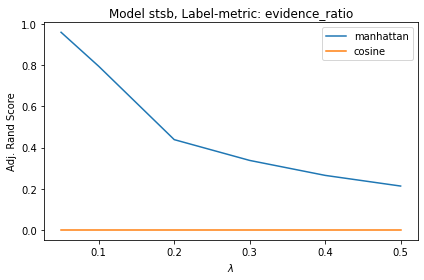

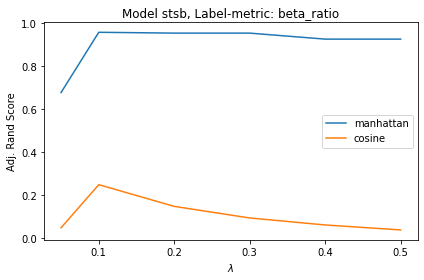

In [26]:
labelmetric = 'evidence_ratio'
for modelname in modelnames:
    for labelmetric in labelmetrics:
        plt.figure()
        plot_lambda_perf_all_metrics(
            plotting_results_df, modelname, labelmetric, all_metrics, stable_threshold=None)
        plt.savefig(modelname+'_'+labelmetric+'_lambdas_vs_adj_rand.png')

In [27]:
def plot_alpha_perf_all_metrics(results, model, labelmetric, all_metrics, stable_threshold=None):
    model_results = results[(results.model == model) & (results.labelmetric == labelmetric)]
    for metric in all_metrics:
        print(f"getting for metric {metric}")
        metric_results = model_results[(model_results.metric == metric)]
        best_row = metric_results[metric_results.adj_rand == metric_results.adj_rand.max()]
        best_lambda = best_row['lambda'].to_numpy()[0]
        if stable_threshold is None:
            threshold = best_row.threshold.to_numpy()[0]
        else:
            threshold = stable_n_clusters
        #best_labelmetric = best_row.labelmetric.to_numpy()[0]
        best_linkage = best_row.linkage.to_numpy()[0]
        best_rescaling = best_row.rescaling.to_numpy()[0]
        alphas, adj_rands = get_alphas_vs_adj_rand(
            metric_results, model, metric, labelmetric, best_lambda, threshold, best_linkage, best_rescaling)
        reorder = np.argsort(alphas)
        adj_rands = adj_rands[reorder]
        alphas = alphas[reorder]
        plt.plot(alphas, adj_rands, label=f'{metric}')
    plt.title(f"Model {modelname}, Label-metric: {labelmetric}")
    plt.xlabel("alpha")
    plt.ylabel("Adj. Rand Score")
    plt.legend()
    plt.tight_layout()

def get_alphas_vs_adj_rand(results, model, metric, labelmetric, lambda_, threshold, linkage, rescaling ):
    segment = results[
        (results.model == model)
        & (results.metric == metric)
        & (results.labelmetric == labelmetric)
        & (results['lambda'] == lambda_)
        & (results.threshold == threshold)
        & (results.linkage == linkage)
        & (results.rescaling == rescaling)]
    alphas = segment.alpha.to_numpy()
    adj_rands = segment.adj_rand.to_numpy()
    return  alphas, adj_rands

getting for metric manhattan
getting for metric cosine
getting for metric manhattan
getting for metric cosine


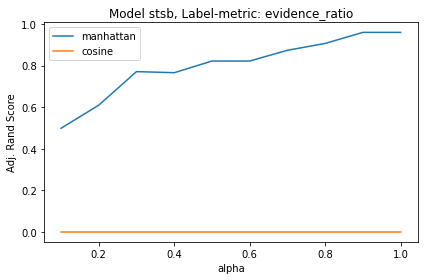

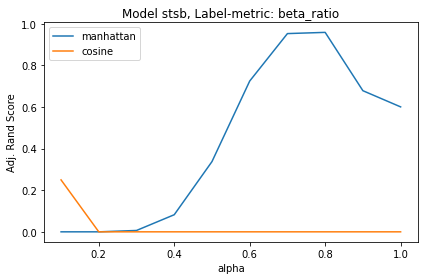

In [28]:
for modelname in modelnames:
    for labelmetric in labelmetrics:
        plt.figure()
        plot_alpha_perf_all_metrics(
            plotting_results_df, modelname, labelmetric, all_metrics, stable_threshold=None)
        plt.savefig(modelname+'_'+labelmetric+'_alphas_vs_adj_rand.png')

In [29]:
plotting_results_df[
    (plotting_results_df.model == best_model)
#    & (plotting_results_df.metric == best_metric)
    & (plotting_results_df.labelmetric != best_labelmetric)
#    & (plotting_results_df.alpha == best_alpha)
#    & (plotting_results_df['lambda'] == best_lambda)
#    & (plotting_results_df.n_clusters == best_n_clusters)
    & (plotting_results_df.adj_rand >0.7)
    ]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling
5,stsb,manhattan,evidence_ratio,0.1,0.05,210.321402,0.834496,single,720.0
59,stsb,manhattan,evidence_ratio,0.2,0.05,210.321402,0.893381,single,720.0
60,stsb,manhattan,evidence_ratio,0.2,0.05,249.236510,0.716332,single,720.0
69,stsb,manhattan,evidence_ratio,0.2,0.10,249.236510,0.769538,single,720.0
112,stsb,manhattan,evidence_ratio,0.3,0.05,177.482393,0.771363,single,720.0
113,stsb,manhattan,evidence_ratio,0.3,0.05,210.321402,0.893381,single,720.0
166,stsb,manhattan,evidence_ratio,0.4,0.05,177.482393,0.766088,single,720.0
167,stsb,manhattan,evidence_ratio,0.4,0.05,210.321402,0.949101,single,720.0
176,stsb,manhattan,evidence_ratio,0.4,0.10,210.321402,0.807854,single,720.0
220,stsb,manhattan,evidence_ratio,0.5,0.05,177.482393,0.822301,single,720.0


In [30]:
plotting_results_df[
    (plotting_results_df.model == best_model)
    & (plotting_results_df.metric != best_metric)
    & (plotting_results_df.labelmetric == best_labelmetric)
#    & (plotting_results_df.alpha == best_alpha)
#    & (plotting_results_df['lambda'] == best_lambda)
    & (plotting_results_df.threshold == best_threshold)
    ]

,model,metric,labelmetric,alpha,lambda,threshold,adj_rand,linkage,rescaling
